In [1]:
import torch
#custom quantization function for matrix
#converting into int8

In [2]:
torch.iinfo(torch.int8)

iinfo(min=-128, max=127, dtype=int8)

In [3]:
int8_min = -128
int8_max = 127

In [131]:
def quantize_func(matrix):
    mat_max = float(matrix.max())
    mat_min = float(matrix.min())
    print(f"old max : {int(mat_max)}")
    print(f"old min : {int(mat_min)}")
    #calculate s scale
    s = (mat_max-mat_min)/(int8_max-int8_min)
    if s == 0:
        s += 1e-9
    #calc zero scale
    z = int(round(int8_min - mat_min/(s)))
    matrix = (matrix/s +z).to(torch.int8)
    print(f"new max : {int(matrix.max())}")
    print(f"new min : {int(matrix.min())}")
    return matrix

In [105]:
mat = torch.randn(size=(3,3))
mat = torch.randint(low=-200,high=200,size=(3,3),dtype=torch.float32) + mat

In [106]:
mat.dtype

torch.float32

In [107]:
mat.max()

tensor(189.0814)

In [108]:
max_mat = mat.max()

In [109]:
float(max_mat)

189.0813751220703

In [110]:
mat_max = float(mat.max())
mat_min = float(mat.min())
s = (mat_max-mat_min)/(int8_max-int8_min)

In [111]:
s

1.1140258190678616

In [112]:
z = int8_min - round((mat_min)/s)

In [113]:
z

-43

In [123]:
z = round(int8_min - (mat_min)/s)

In [124]:
z

-43

In [135]:
q_mat = ((mat/s)+z).to(torch.int8)

In [136]:
q_mat

tensor([[ 126, -128,   61],
        [-108,   31,  -56],
        [-104,  -32,   90]], dtype=torch.int8)

In [137]:
mat

tensor([[189.0814, -94.9952, 116.9630],
        [-72.9081,  82.6603, -15.5534],
        [-68.8096,  11.4384, 148.5298]])

In [138]:
deq_mat = s * (q_mat - z)

In [139]:
deq_mat

tensor([[ -96.9202,  -94.6922,  115.8587],
        [ -72.4117,   82.4379,  -14.4823],
        [ -67.9556,   12.2543, -137.0252]])

In [140]:
mat - deq_mat

tensor([[ 2.8600e+02, -3.0302e-01,  1.1043e+00],
        [-4.9642e-01,  2.2243e-01, -1.0711e+00],
        [-8.5401e-01, -8.1584e-01,  2.8555e+02]])

In [141]:
def quantize_func(matrix):
    mat_max = float(matrix.max())
    mat_min = float(matrix.min())
    print(f"old max : {int(mat_max)}")
    print(f"old min : {int(mat_min)}")

    # Calculate s scale
    s = (mat_max - mat_min) / (int8_max - int8_min + 1e-9)

    # Calculate zero scale
    z = int(round(int8_min - mat_min / (s + 1e-9)))

    # Quantize the matrix
    quantized_matrix = (matrix / s + z).to(torch.int8)
    
    # Print new quantized values
    print(f"new max : {int(quantized_matrix.max())}")
    print(f"new min : {int(quantized_matrix.min())}")

    # Dequantize the matrix
    dequantized_matrix = s * (quantized_matrix - z)
    
    # Print dequantized values
    print("Dequantized matrix:")
    print(dequantized_matrix)

    return quantized_matrix, dequantized_matrix

# Example usage
int8_min = -128
int8_max = 127
matrix = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])

quantized_matrix, dequantized_matrix = quantize_func(matrix)

# Verify the results
print("Quantized matrix:")
print(quantized_matrix)

print("Dequantized matrix:")
print(dequantized_matrix)

old max : 6
old min : 1
new max : 127
new min : -128
Dequantized matrix:
tensor([[ 1.0000,  2.0000, -2.0196],
        [-1.0196, -0.0392,  0.9804]])
Quantized matrix:
tensor([[-128,  -77,  -26],
        [  25,   75,  127]], dtype=torch.int8)
Dequantized matrix:
tensor([[ 1.0000,  2.0000, -2.0196],
        [-1.0196, -0.0392,  0.9804]])


In [144]:
error = matrix - dequantized_matrix

In [145]:
error

tensor([[0.0000, 0.0000, 5.0196],
        [5.0196, 5.0392, 5.0196]])

In [67]:
def quantize_tensor(tensor,dtype=torch.int8):
    r_max = tensor.max()
    r_min = tensor.min()
    tensor_dtype = tensor.dtype
    q_max = torch.iinfo(dtype).max
    q_min = torch.iinfo(dtype).min
    #scale must be in higher precision
    scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)
    zero = int(torch.round(q_min - (r_min/scale)))
    q_tensor = tensor/scale + zero
    rounded_tensor = torch.round(q_tensor)
    rounded_tensor = rounded_tensor.clamp(q_min,q_max).to(dtype)
    return rounded_tensor,scale,zero

In [68]:
x = torch.randint(low=-150,high=150,size=(3,3),dtype=torch.float32) 
y = torch.randn(3,3,dtype=torch.float32)
z = x+y

In [69]:
z.dtype

torch.float32

In [70]:
z[0,1] = 0
z

tensor([[-132.4939,    0.0000,  -68.0128],
        [  -2.8319,  106.6731, -126.6552],
        [-108.3010,  -75.1935,   13.3175]])

In [71]:
q_z,scale,zero = quantize_tensor(z)

/var/folders/xw/knd54pd91c7cw57n21dntvx80000gn/T/ipykernel_14786/64016656.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  scale = torch.tensor((r_max-r_min)/(q_max-q_min),dtype=tensor_dtype)


In [72]:
q_z

tensor([[-128,   13,  -60],
        [  10,  127, -122],
        [-102,  -67,   27]], dtype=torch.int8)

In [73]:
def de_quantize(tensor,scale,zero,dtype=torch.float32):
    deq_tensor = scale * (tensor - zero)
    return deq_tensor

In [74]:
z_de = de_quantize(q_z,scale,zero)

In [75]:
z_de

tensor([[ 107.8596,    0.0000,  -68.4674],
        [  -2.8137,  106.9217,  113.4871],
        [-107.8596,  -75.0328,   13.1307]])

In [76]:
#quantization error
error = z - z_de

<Axes: >

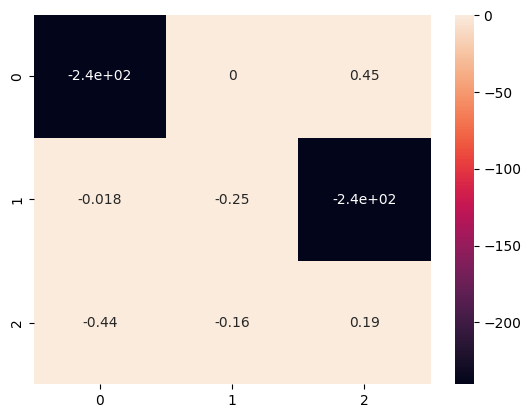

In [77]:
import seaborn as sns
sns.heatmap(error.numpy(),annot=True)

In [78]:
error

tensor([[-2.4035e+02,  0.0000e+00,  4.5461e-01],
        [-1.8150e-02, -2.4865e-01, -2.4014e+02],
        [-4.4132e-01, -1.6069e-01,  1.8673e-01]])